# 缺失值处理（Missing Value Handling）

## 1. 模块概述

在真实数据中，缺失值（Missing Value）无处不在。合理地检测与处理缺失值，能够：
- 避免后续模型训练出现报错或性能下降；
- 减少对统计量（如均值、方差）的偏差影响；
- 保存数据中的大部分有效信息。

分为以下几个 Block：
1. **缺失值概述**：缺失值的产生原因与分类（MCAR、MAR、MNAR）；  
2. **缺失值检测**：使用 Pandas 及可视化手段识别数据集中缺失值分布；  
3. **删除法（Drop）**：直接删除含缺失值的行或列，适用于缺失率极低场景；  
4. **简单插补（Simple Imputation）**：使用均值、中位数、众数填充，适用于基础场景；  
5. **KNN 插补（KNN Imputer）**：基于相似样本的插补方法，用于高缺失率或变量间相关性较强场景；  
6.（可选）**多种插补方法对比**：对比不同插补策略对简单回归模型的影响。

每个 Block 都包含理论讲解（Markdown）和至少一个代码示例（Python + Pandas/Scikit-learn）。


## 2. 缺失值概述（Theory）

### 2.1 缺失值的三种类型
1. **MCAR（Missing Completely At Random）**  
   - 定义：缺失与任何已观测或未观测变量都无关，随机分布。  
   - 影响：样本删除不会引入偏差，但会损失样本量。  

2. **MAR（Missing At Random）**  
   - 定义：缺失值与其他观测到的特征有关，但与该缺失特征本身的取值无关。  
   - 影响：可通过建模或条件插补来校正偏差。  

3. **MNAR（Missing Not At Random）**  
   - 定义：缺失值与自身取值相关（例如，收入高的人不愿意填写收入）。  
   - 影响：插补或删除都可能引入较大偏差，需要领域知识进行特殊处理。

### 2.2 缺失值带来的问题
- 直接将带缺失值的数据输入大多数机器学习算法（如线性回归、树模型等）会报错。  
- 如果简单删除缺失行，样本量下降，可能导致欠拟合。  
- 如果随意插补（如统一使用均值），可能引入系统性偏差，影响模型预测性能。

### 2.3 实际场景举例
- **问卷调查**：受访者可能漏填某些敏感问题。  
- **传感器数据**：传感器故障或传输中断导致数据丢失。  
- **医疗数据**：部分检查项目缺失。  
- **业务日志**：部分字段因上报流程异常而为空。



## 3. 缺失值检测（Detection）

### 3.1 在 Pandas 中检测缺失值
- 使用 `df.isnull()` 或 `df.isna()` 可以生成一个与原 DataFrame 同尺寸的布尔型 DataFrame，标记所有缺失位置。  
- 通过 `df.isnull().sum()` 可以统计每一列中缺失值的总数。  
- 通过 `df.isnull().mean()` 可以计算每一列的缺失率，即缺失值数目除以总行数。  
- `df.info()` 方法会显示各列的非空（non-NA）计数，与总行数进行对比即可判断缺失情况。

### 3.2 缺失率计算与阈值筛选
- 如果想要知道哪几列缺失严重，可以先计算按列缺失率，然后根据阈值进行筛选：  
  - 统计每列缺失率：采用 `df.isnull().mean()`。  
  - 统计每行缺失率：采用 `df.isnull().mean(axis=1)`。  
- 当某列缺失率超过预设阈值（例如 50%）时，就可以考虑直接删除该列。  
- 当某行缺失率较高时（超过某个百分比），可以考虑删除该行，或者对其进行特殊处理。

### 3.3 可视化缺失模式
- 可以利用 Seaborn 绘制热力图，将缺失位置用不同颜色标记，一目了然地知道哪些行列存在缺失。  
- 若安装了 `missingno` 库，还可以使用它生成更专业的缺失矩阵图或缺失条形图，以便观察缺失随行索引或列之间的相关模式。  
- 通过可视化，我们可以发现集中缺失的行、整体缺失的列，或者不同列之间缺失是否具有关联性。

### 3.4 关注缺失模式的时机
- 如果某几行有大量列同时缺失，说明数据采集环节可能出现严重异常，需要单独对这些行进行审查或删除。  
- 如果某列整体缺失严重，往往意味着该特征本身质量较差，可能需要删除该列或寻找替代特征。  
- 当缺失模式并非随机分布（如某个子集系统地缺失）时，需要认真评估缺失机制，决定后续插补策略或结合领域知识介入。


每列缺失值数量：
age          3
salary       3
city         0
education    3
score        3
target       0
dtype: int64

每列缺失率（%）：
age          20.0
salary       20.0
city          0.0
education    20.0
score        20.0
target        0.0
dtype: float64

每行缺失率（前5行）：
0    0.000000
1    0.333333
2    0.000000
3    0.333333
4    0.166667
dtype: float64


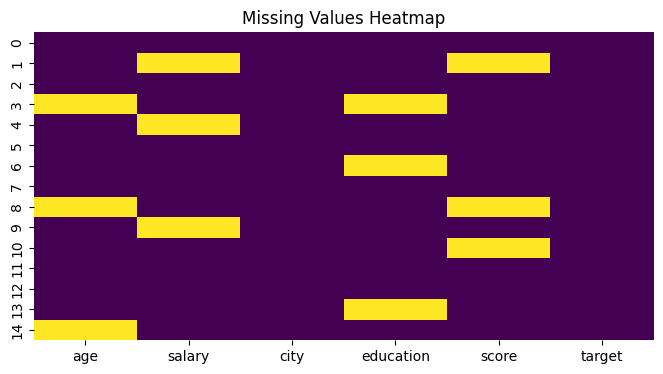

In [5]:
# === 修正后的代码示例：缺失值检测与可视化 ===

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 构造示例 DataFrame（带缺失）
np.random.seed(2025)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, size=15),
    'salary': np.random.randint(3000, 10000, size=15),
    'city': np.random.choice(['Beijing', 'Shanghai', 'Guangzhou'], size=15),
    'education': np.random.choice(['HighSchool', 'Bachelor', 'Master', 'PhD'], size=15),
    'score': np.random.uniform(0, 100, size=15),
    'target': np.random.choice([0, 1], size=15)
})

# 人为插入缺失值（约 20% 的比例）
for col in ['age', 'salary', 'education', 'score']:
    # 使用一个有效的随机种子：abs(hash(col)) % (2**32)
    seed = abs(hash(col)) % (2**32)
    df.loc[df.sample(frac=0.2, random_state=seed).index, col] = np.nan

# 基本缺失值统计
missing_count = df.isnull().sum()
missing_rate = df.isnull().mean()
row_missing_rate = df.isnull().mean(axis=1)

print("每列缺失值数量：")
print(missing_count)
print("\n每列缺失率（%）：")
print((missing_rate * 100).round(2))
print("\n每行缺失率（前5行）：")
print(row_missing_rate.head())

# Seaborn 热力图可视化缺失分布
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# 如果已安装 missingno 库，可使用以下代码（已注释）
# import missingno as msno
# msno.matrix(df)
# plt.show()
# msno.bar(df)
# plt.show()


## 4. 删除法（Dropping）

### 4.1 原理与方法
- **删除缺失行**  
  - `df.dropna(axis=0, how='any')`：删除包含任意缺失值的行。  
  - `df.dropna(axis=0, how='all')`：仅删除所有值均为缺失的行。  
- **删除缺失列**  
  - `df.dropna(axis=1, how='any')`：删除包含任意缺失值的列。  
  - `df.dropna(axis=1, how='all')`：仅删除所有值均为缺失的列。  
- **按阈值删除**  
  - `df.dropna(axis=0, thresh=k)`：保留至少有 k 个非缺失值的行，其它行删除。  
  - `df.dropna(axis=1, thresh=k)`：保留至少有 k 个非缺失值的列，其它列删除。  
- **适用场景**  
  1. 当缺失值占比非常小（例如 < 5%）时，删除行往往对样本几乎无损。  
  2. 当某列缺失率过高（例如 > 50%）时，删除该列可能比插补更简单且不易引入偏差。  

### 4.2 优缺点
- **优点**  
  - 实现简单、速度快。  
  - 不会引入额外的插补偏差。  
- **缺点**  
  - 可能导致样本量骤减，尤其当缺失分布分散在多列时。  
  - 如果缺失并非完全随机（MCAR），删除行或列可能引入系统性偏差。  
  - 删除列意味着放弃了所有该列可能包含的信息。



In [6]:
# === 代码示例：删除法（Dropping） ===

import pandas as pd
import numpy as np

# 构造示例 DataFrame（沿用前一 Block 的 df）
np.random.seed(2025)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, size=15),
    'salary': np.random.randint(3000, 10000, size=15),
    'city': np.random.choice(['Beijing', 'Shanghai', 'Guangzhou'], size=15),
    'education': np.random.choice(['HighSchool', 'Bachelor', 'Master', 'PhD'], size=15),
    'score': np.random.uniform(0, 100, size=15),
    'target': np.random.choice([0, 1], size=15)
})

# 再次插入缺失值（约 20%）
for col in ['age', 'salary', 'education', 'score']:
    seed = abs(hash(col)) % (2**32)
    df.loc[df.sample(frac=0.2, random_state=seed).index, col] = np.nan

print("原始数据形状：", df.shape)
print("原始数据缺失情况：\n", df.isnull().sum(), "\n")

# ---------- 4.1 删除含任意缺失值的行 ----------
df_drop_any = df.dropna(axis=0, how='any')
print("删除含任意缺失值行后形状：", df_drop_any.shape)
print("删除后缺失检查：\n", df_drop_any.isnull().sum(), "\n")

# ---------- 4.2 删除缺失比例超过阈值的列（保留至少 80% 非缺失值） ----------
threshold = int(df.shape[0] * 0.8)  # 至少需 80% 行非缺失
df_drop_thresh = df.dropna(axis=1, thresh=threshold)
print("阈值删除后剩余列：", df_drop_thresh.columns.tolist())
print("剩余列的缺失检查：\n", df_drop_thresh.isnull().sum(), "\n")

# ---------- 4.3 删除所有值均为缺失的行或列（示例） ----------
# 为了演示 how='all'，先人为设置一整列为缺失
df_temp = df.copy()
df_temp['all_missing'] = np.nan
print("添加全空列后形状：", df_temp.shape)

# 删除值全为缺失的列
df_drop_all_cols = df_temp.dropna(axis=1, how='all')
print("删除值全为缺失的列后形状：", df_drop_all_cols.shape)


原始数据形状： (15, 6)
原始数据缺失情况：
 age          3
salary       3
city         0
education    3
score        3
target       0
dtype: int64 

删除含任意缺失值行后形状： (6, 6)
删除后缺失检查：
 age          0
salary       0
city         0
education    0
score        0
target       0
dtype: int64 

阈值删除后剩余列： ['age', 'salary', 'city', 'education', 'score', 'target']
剩余列的缺失检查：
 age          3
salary       3
city         0
education    3
score        3
target       0
dtype: int64 

添加全空列后形状： (15, 7)
删除值全为缺失的列后形状： (15, 6)


## 5. 简单插补（Simple Imputation）

### 5.1 原理与方法
- **均值插补（Mean Imputation）**  
  - 原理：将数值型特征中的缺失值替换为该列所有非缺失值的均值。  
  - 适用场景：缺失率较低且特征分布近似对称时。  
- **中位数插补（Median Imputation）**  
  - 原理：将缺失值替换为该列的中位数，适合数据分布偏态时使用。  
  - 适用场景：存在离群值或数据分布不对称时。  
- **众数插补（Mode Imputation）**  
  - 原理：将类别型特征缺失值替换为出现频率最高的类别（众数）。  
  - 适用场景：类别特征缺失率较低、且类别数目不多时。

### 5.2 优缺点
- **优点**  
  - 实现简单、速度快。  
  - 对于低缺失率数据，一般不会对整体分布产生巨大破坏。  
- **缺点**  
  - 会低估特征的方差，因为所有缺失均被替换为同一个数值。  
  - 无法利用其他特征间的相关信息，可能会引入系统性偏差。  
  - 对于高缺失率或复杂缺失机制（MAR、MNAR），效果较差。

### 5.3 实践流程
1. **区分数值型与类别型特征**  
   - 数值型特征可采用均值或中位数插补。  
   - 类别型特征可采用众数插补，或先将缺失值标记为新类别再做编码。  
2. **在训练集上计算插补值**  
   - 对训练集 `df_train`，分别计算每列的均值/中位数/众数。  
3. **在训练集与测试集上应用插补**  
   - 在训练集上使用 `fillna`（或 `SimpleImputer.fit_transform`）；  
   - 同一插补策略和参数应用到测试集（`fit` 阶段仅在训练集）。  
4. **插补后再次检查缺失**  
   - 确保插补后所有缺失已被填充，可使用 `df.isnull().sum()` 校验。  

---
**本 Block 目标：**  
1. 掌握使用均值、中位数和众数对缺失值进行填充的方法。  
2. 理解各方法在不同数据分布与缺失率下的适用性与局限性。  
3. 能够在训练-测试流程中正确地 fit 然后 transform，避免数据泄漏。


In [7]:
# === 代码示例：简单插补（Simple Imputation） ===

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# 构建示例 DataFrame（带缺失）
np.random.seed(2025)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, size=15),
    'salary': np.random.randint(3000, 10000, size=15),
    'education': np.random.choice(['HighSchool', 'Bachelor', 'Master', 'PhD'], size=15),
    'score': np.random.uniform(0, 100, size=15),
    'target': np.random.choice([0, 1], size=15)
})
# 插入缺失值（约 20%）
for col in ['age', 'salary', 'education', 'score']:
    seed = abs(hash(col)) % (2**32)
    df.loc[df.sample(frac=0.2, random_state=seed).index, col] = np.nan

print("插补前缺失情况：")
print(df.isnull().sum(), "\n")

# ---------- 5.1 Pandas 原生插补方式 ----------
df_pandas = df.copy()

# 数值型：age 和 salary 用均值、中位数插补
df_pandas['age'] = df_pandas['age'].fillna(df_pandas['age'].mean())
df_pandas['salary'] = df_pandas['salary'].fillna(df_pandas['salary'].median())

# 类别型：education 用众数插补
mode_edu = df_pandas['education'].mode()[0]
df_pandas['education'] = df_pandas['education'].fillna(mode_edu)

# 数值型：score 用均值插补
df_pandas['score'] = df_pandas['score'].fillna(df_pandas['score'].mean())

print("Pandas 插补后缺失情况：")
print(df_pandas.isnull().sum(), "\n")

# ---------- 5.2 Scikit-learn SimpleImputer 示例 ----------
# 仅对数值型列进行均值插补
df_numeric = df[['age', 'salary', 'score']]

# 创建 SimpleImputer 对象
imputer_mean = SimpleImputer(strategy='mean')
# 在训练集上 fit（此处 df 视作训练集）
imputer_mean.fit(df_numeric)

# transform 会返回 numpy 数组，需要转回 DataFrame
df_num_imputed = pd.DataFrame(
    imputer_mean.transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)

# 将插补后的数值列替换回原始 DataFrame
df_imputed = df.copy()
df_imputed[['age', 'salary', 'score']] = df_num_imputed

# 对类别型列 education 用众数插补
df_imputed['education'] = df_imputed['education'].fillna(df_imputed['education'].mode()[0])

print("Scikit-learn 插补后缺失情况：")
print(df_imputed.isnull().sum())


插补前缺失情况：
age          3
salary       3
education    3
score        3
target       0
dtype: int64 

Pandas 插补后缺失情况：
age          0
salary       0
education    0
score        0
target       0
dtype: int64 

Scikit-learn 插补后缺失情况：
age          0
salary       0
education    0
score        0
target       0
dtype: int64


## 6. KNN 插补（KNN Imputer）

### 6.1 原理与方法
- **KNN 插补思想**  
  - 对于某个存在缺失值的样本，KNN 插补会在“特征空间”中寻找与该样本最相似的 K 个邻近样本（这些邻近样本在缺失的列上有观测值），然后使用这 K 个邻近样本在该列的平均值或加权平均值来填充缺失。  
  - 该方法能够利用其他特征之间的相关性，实现比均值/中位数插补更精准的填充。

- **参数说明**  
  - `n_neighbors`：邻近样本数量 K。  
  - `weights`：权重类型，可选 `'uniform'`（平均）或 `'distance'`（根据距离加权）。  
  - `metric`：距离度量方式，默认 `'nan_euclidean'`，表示忽略缺失值后计算欧氏距离。

- **适用场景**  
  1. 当缺失率中等（如 10%–30%）且各特征之间关联较强时。  
  2. 希望保留更多样本而不进行行删除。  
  3. 对填充值的精度要求较高，且能接受一定的计算开销。

- **优缺点**  
  - **优点**：  
    1. 考虑到了多个特征之间的相关性，插补结果更接近真实数据分布。  
    2. 不会大幅低估方差。  
  - **缺点**：  
    1. 需要计算样本之间的距离，计算量大，随数据量和维度增长速度加快。  
    2. 对离群值敏感，距离计算时可能被极端值干扰。  
    3. 使用前需对数值特征做标准化/归一化，否则尺度不同会影响距离计算。

### 6.2 实践流程
1. **准备数值特征矩阵**  
   - 将原始 DataFrame 中的数值型特征提取出来，组成一个仅包含数值列的矩阵（含缺失）。  
   - 若同时存在类别特征，需要先将类别特征编码或临时剔除，只对数值列做 KNN 插补。  
2. **创建并训练 KNNImputer**  
   - 在训练集上执行 `knn_imputer.fit()`，让算法学习缺失模式与邻近关系。  
3. **对训练集与测试集进行插补**  
   - 使用 `knn_imputer.transform()` 将缺失值填充，返回完整的数值矩阵。  
   - 将插补后的矩阵重新赋值回原 DataFrame 的对应列。  
4. **对类别特征进行后续处理**  
   - 若类别列也存在缺失，可在 KNN 插补数值列后，再使用众数插补或其他方式填充类别缺失。

In [8]:
# === 代码示例：KNN 插补（KNN Imputer） ===

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 构造示例 DataFrame（带缺失）
np.random.seed(2025)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, size=15),
    'salary': np.random.randint(3000, 10000, size=15),
    'education': np.random.choice(['HighSchool', 'Bachelor', 'Master', 'PhD'], size=15),
    'score': np.random.uniform(0, 100, size=15),
    'target': np.random.choice([0, 1], size=15)
})

# 人为插入缺失值（约 20%）
for col in ['age', 'salary', 'education', 'score']:
    seed = abs(hash(col)) % (2**32)
    df.loc[df.sample(frac=0.2, random_state=seed).index, col] = np.nan

print("插补前缺失情况：")
print(df.isnull().sum(), "\n")

# ---------- 6.1 提取数值列并执行 KNN 插补 ----------
num_cols = ['age', 'salary', 'score']
df_num = df[num_cols].copy()

# 创建 KNNImputer，设置邻近数为 3
knn_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')

# 在数值列上 fit 并 transform
df_num_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_num),
    columns=num_cols,
    index=df.index
)

# 将插补后的数值列赋回原 DataFrame
df_knn = df.copy()
df_knn[num_cols] = df_num_imputed

# ---------- 6.2 对类别列进行后续众数插补 ----------
mode_edu = df_knn['education'].mode()[0]
df_knn['education'] = df_knn['education'].fillna(mode_edu)

print("KNN 插补 + 众数插补后缺失情况：")
print(df_knn.isnull().sum(), "\n")

# 查看插补前后对比
print("原始缺失样本：")
print(df.loc[df['age'].isnull() | df['salary'].isnull() | df['score'].isnull(), :])
print("\n插补后对应样本：")
print(df_knn.loc[df['age'].isnull() | df['salary'].isnull() | df['score'].isnull(), :])


插补前缺失情况：
age          3
salary       3
education    3
score        3
target       0
dtype: int64 

KNN 插补 + 众数插补后缺失情况：
age          0
salary       0
education    0
score        0
target       0
dtype: int64 

原始缺失样本：
     age  salary   education      score  target
1   38.0     NaN         PhD        NaN       1
3    NaN  4168.0         NaN  14.708371       0
4   23.0     NaN      Master   6.272126       1
8    NaN  8017.0  HighSchool        NaN       0
9   57.0     NaN      Master  99.346406       0
10  30.0  9608.0      Master        NaN       1
14   NaN  5849.0    Bachelor  72.290374       0

插补后对应样本：
          age       salary   education      score  target
1   38.000000  6066.333333         PhD  33.762709       1
3   43.333333  4168.000000    Bachelor  14.708371       0
4   23.000000  6787.666667      Master   6.272126       1
8   39.333333  8017.000000  HighSchool  44.049293       0
9   57.000000  6787.000000      Master  99.346406       0
10  30.000000  9608.000000      Master  6

## 7. 插补方法对比实验（Comparison）

### 7.1 实验目的
- 比较不同缺失值处理策略对下游模型性能的影响。  
- 常见策略包括：  
  1. **删除缺失（Dropping）**  
  2. **均值插补（Mean Imputation）**  
  3. **KNN 插补（KNN Imputer）**  
- 通过同一份带缺失的回归数据集，分别使用以上三种策略处理，然后在相同的线性回归模型上进行训练和评估，观察 MSE（均方误差）和 R²（决定系数）指标。

### 7.2 实验流程
1. **构造带缺失的回归数据集**  
   - 生成两个数值特征 X1、X2 和目标 y；  
   - 向 X1、X2 中随机插入缺失。  
2. **划分训练集与测试集**  
   - 按比例随机划分，例如 70% 训练，30% 测试。  
3. **分别应用三种缺失值处理方法**  
   - *删除法*：在训练集和测试集中均删除含缺失的行；  
   - *均值插补*：在训练集上计算均值并应用于训练集和测试集；  
   - *KNN 插补*：在训练集上 fit KNNImputer，并对训练集和测试集进行 transform；  
4. **同一模型训练与评估**  
   - 使用线性回归模型分别在三种处理后得到的数据上训练；  
   - 在相应测试集上计算 MSE、R²，记录训练样本量。  
5. **对比结果并讨论**  
   - 比较各策略下模型的 MSE 和 R²，以及训练样本量变化；  
   - 分析在本数据集条件下，哪种插补策略更合适。

In [9]:
# === 代码示例：插补方法对比实验（Comparison） ===

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# ---------- 7.1 构造带缺失的回归数据集 ----------
np.random.seed(2025)
N = 200
X1 = np.random.normal(50, 10, size=N)
X2 = np.random.normal(30, 5, size=N)
y = 2 * X1 - 3 * X2 + np.random.normal(0, 5, size=N)

df_reg = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})

# 在 X1 和 X2 中随机插入缺失值（约 20%）
for col in ['X1', 'X2']:
    seed = abs(hash(col)) % (2**32)
    df_reg.loc[df_reg.sample(frac=0.2, random_state=seed).index, col] = np.nan

# 划分训练集与测试集（70% 训练，30% 测试）
df_train, df_test = train_test_split(df_reg, test_size=0.3, random_state=42)
X_train = df_train[['X1', 'X2']]
y_train = df_train['y']
X_test = df_test[['X1', 'X2']]
y_test = df_test['y']

results = {}

# ---------- 方法 1：删除含缺失行 ----------
X_train_drop = X_train.dropna(axis=0, how='any')
y_train_drop = y_train.loc[X_train_drop.index]
X_test_drop = X_test.dropna(axis=0, how='any')
y_test_drop = y_test.loc[X_test_drop.index]

model_drop = LinearRegression()
model_drop.fit(X_train_drop, y_train_drop)
y_pred_drop = model_drop.predict(X_test_drop)
results['drop'] = {
    'MSE': mean_squared_error(y_test_drop, y_pred_drop),
    'R2': r2_score(y_test_drop, y_pred_drop),
    '训练样本量': len(X_train_drop)
}

# ---------- 方法 2：均值插补 ----------
imputer_mean = SimpleImputer(strategy='mean')
imputer_mean.fit(X_train)

X_train_mean = pd.DataFrame(imputer_mean.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imputer_mean.transform(X_test), columns=X_test.columns, index=X_test.index)

model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)
y_pred_mean = model_mean.predict(X_test_mean)
results['mean_impute'] = {
    'MSE': mean_squared_error(y_test, y_pred_mean),
    'R2': r2_score(y_test, y_pred_mean),
    '训练样本量': len(X_train_mean)
}

# ---------- 方法 3：KNN 插补 ----------
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')
imputer_knn.fit(X_train)

X_train_knn = pd.DataFrame(imputer_knn.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_knn = pd.DataFrame(imputer_knn.transform(X_test), columns=X_test.columns, index=X_test.index)

model_knn = LinearRegression()
model_knn.fit(X_train_knn, y_train)
y_pred_knn = model_knn.predict(X_test_knn)
results['knn_impute'] = {
    'MSE': mean_squared_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn),
    '训练样本量': len(X_train_knn)
}

# ---------- 7.2 输出对比结果 ----------
import pprint
pp = pprint.PrettyPrinter(indent=2, width=80, compact=True)
print("=== 三种缺失值处理方法对比 ===")
pp.pprint(results)


=== 三种缺失值处理方法对比 ===
{ 'drop': {'MSE': 18.08833665536671, 'R2': 0.9731886073543916, '训练样本量': 87},
  'knn_impute': { 'MSE': 53.40374545537905,
                  'R2': 0.9106033740148243,
                  '训练样本量': 140},
  'mean_impute': { 'MSE': 61.88492199933005,
                   'R2': 0.8964060820281166,
                   '训练样本量': 140}}


## 8. 小结与建议（Summary）

### 8.1 各种缺失值处理方法优缺点对比

| 方法                 | 优点                                                       | 缺点                                                                  | 适用场景                                           |
|----------------------|-----------------------------------------------------------|-----------------------------------------------------------------------|----------------------------------------------------|
| **删除（Dropping）**  | - 实现简单、速度快<br>- 不会引入插补偏差                     | - 样本量可能骤减，尤其当缺失分布在多列时<br>- 如果缺失非 MCAR，会引入系统性偏差 | - 当缺失率极低（<5%）且缺失分布接近随机时<br>- 某列缺失率非常高（>50%），但该列对建模价值不大时，可删除 |
| **均值/中位数插补**   | - 实现简便、计算开销小<br>- 对于低缺失率数据，分布扰动较小   | - 会低估特征方差<br>- 忽略其他特征间相关性，可能引入偏差               | - 缺失率较低（<10–15%），且特征分布近似对称时       |
| **众数插补**         | - 类别型缺失快速填充<br>- 对类别特征简单直观                 | - 可能过度集中某一类，破坏类别分布                                      | - 类别特征缺失率较低（<10%），且类别数不多时         |
| **KNN 插补**         | - 利用多特征相关性，插补更贴近真实值<br>- 不会严重低估方差   | - 计算开销大（需计算距离）<br>- 对离群值敏感<br>- 需先做标准化         | - 缺失率中等（10–30%），且特征间关联度较高时         |
| **多重插补（MICE）** | - 可模拟多个插补数据集，估计参数不确定性<br>- 统计推断更可靠 | - 实现复杂，计算量大<br>- 需多次迭代且对高维变量性能可能变差          | - 高缺失率（>30%）或 MNAR 情况下，需要对插补不确定性进行评估时 |

---

### 8.2 实战建议

1. **先评估缺失率与缺失模式**  
   - 通过 `df.isnull().mean()` 获得缺失率，判断哪些列或行缺失严重。  
   - 如果发现缺失集中在某些行或列，首先检查数据采集流程是否存在问题。  

2. **区分缺失机制**  
   - 当缺失近似 MCAR，可考虑删除或简单插补；  
   - 如果缺失属于 MAR，可使用基于多变量的插补（KNN、MICE 或基于树的模型插补）减少偏差；  
   - 若怀疑 MNAR，需要结合领域知识，对该特征做单独建模或敏感性分析。  

3. **选择合适的插补方法**  
   - 缺失率 < 5%：可考虑删除含缺失行；  
   - 缺失率 5%–15%：简单插补（均值/中位数/众数）通常足够；  
   - 缺失率 15%–30%：可尝试 KNN 插补或基于树的插补（如 MissForest）；  
   - 缺失率 > 30%：优先评估该特征的重要性，若保留，再使用多重插补（MICE）并评估不确定性。  

4. **保持流水线一致性，避免数据泄漏**  
   - 始终在训练集上 `fit`（如计算均值、训练 KNN），然后将同一插补模型应用于训练与测试集；  
   - 可使用 `sklearn.pipeline.Pipeline` 将插补与后续操作（如标准化、模型训练）串联，确保流程统一。  

5. **插补后进行诊断和可视化**  
   - 对比插补前后特征分布（直方图、箱线图）是否差异过大；  
   - 查看插补后数据与原始观测值的相关性矩阵是否合理；  
   - 如果插补后分布出现明显异常，需尝试其他策略或结合领域专家意见。  

6. **结合领域知识与业务需求**  
   - 特殊场景下（如医疗、金融），缺失本身可能具有重要信息（如 MNAR），不能简单忽略；  
   - 与业务专家沟通，了解缺失背后的真实原因，并根据业务价值决定保留或删除；  
   - 评估不同插补方案对下游指标（如模型预测效果、业务指标）是否有实质改进。  

---

### 8.3 小结

- 缺失值处理贯穿数据预处理的首要环节——若不认真处理，会严重影响后续模型训练与性能。  
- 不同方法各有优劣，需要结合缺失率、缺失机制和业务场景综合决策。  
- 通过实验（如对比不同插补策略在同一模型上的表现）可以更直观地判断最佳方案。  
- 最终要确保流水线一致性，避免在测试集上重复 `fit`，并在插补后对数据分布进行诊断，确保填充结果合理。  
- 完成所有插补与删除步骤后，数据才算真正“干净”，即可进入下一阶段的特征缩放与转换工作。  
